# Entraînement supervisé
Ce notebook est dédié à l'entraînement supervisé, dont l'objectif principal est de comparer différentes méthodes d'entraînement supervisé afin de déterminer laquelle offre les meilleures performances pour notre projet. Nous allons explorer une variété d'algorithmes, chacun avec ses propres avantages et inconvénients, et évaluer leur efficacité selon plusieurs critères.

In [1]:
# Imports nécessaires pour ce notebook
# Imports standard
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Imports de géotraitement
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

# Imports de sklearn - Prétraitement
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Imports de sklearn - Modèles
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Imports de sklearn - Évaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score

# Imports d'imblearn
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

## Importation des données
Les données utilisées ont été extraites et combinées dans un précédent notebook, puis enregistrées dans un unique fichier, afin de faciliter leur utilisation.

In [2]:
csv_path = '../../data/processed/processed_enhanced_data_with_presence.csv'

# Lecture du GeoDataFrame à partir du CSV
gdf = pd.read_csv(csv_path)

# Applications de paramètres liés à la geometry du GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.set_crs(epsg=2056, inplace=True)

gdf.head()

,idx,geometry,Altitude,NaturalHabitat,SoilType,WaterRetention,NutrientContent,WaterPermeability,Temperature,Presence,Count
0,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2,0,0
1,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2,0,0
2,261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3,0,0
3,262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3,0,0
4,263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.3,0,0


## Préparation du pipeline de prétraitement

Les données ne peuvent malheureusement pas être utilisées en tant que tel et nécessitent un prétraitement, afin de pouvoir effectuer un apprentissage correct. Une partie des colonnes va également être abandonnées, celles-ci n'étant pas pertinentes dans l'entraînement des modèles.

Les traitements effectués sont les suivants :

- Normalisation des variables numériques `Altitude` et `Temperature` : Certains modèles étant sensibles aux différences d’échelle entre les variables, il est préférable de normaliser les valeurs en les ramenant dans un intervalle compris entre 0 et 1. Cette transformation permet d’éviter que ces écarts n’impactent les performances des modèles.

- Transformation one-hot pour les variables catégorielles

    - `NaturalHabitat` : Bien que cette variable utilise des valeurs numériques, celles-ci ne représentent aucune relation hiérarchique ou d’ordre entre elles. Seul un regroupement implicite existe pour les classes partageant la même dizaine. Par conséquent, l’encodage one-hot est privilégié pour améliorer les performances des modèles.
      
    - `SoilType` : Comme mis en évidence lors de l’analyse exploratoire, cette variable regroupe différents types de sols. Les tests effectués montrent que l’utilisation d’une transformation one-hot donne de meilleurs résultats que la séparation préalable des types en plusieurs colonnes binaires.
 
    - `WaterRetention`, `NutrientContent` et `WaterPermeability` : Bien que ces variables soient exprimées sous forme numérique et ordonnée, nos tests ont démontré que les performances des modèles s’améliorent lorsque ces variables sont encodées via une transformation one-hot.
      
- Abandon des colonnes `idx` et `geometry` car celles-ci ne sont pas adaptées aux tests effectués ici. À noter que la position géographique peut être utilisée uniquement si `geometry` est décomposée. Nous n'avons pas abandonné d'autres attributs, car nous n'avons pas observé d'amélioration lorsque nous le faisons.



In [3]:
numeric_features = ['Altitude', 'Temperature']
categorical_features = ['NaturalHabitat', 'SoilType', 'WaterRetention', 'NutrientContent', 'WaterPermeability']
columns_to_drop = ['idx', 'geometry']

In [4]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('numerical', numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

Pour plus de facilité dans la sélection des hyperparamètres des modèles, le nombre de features restantes est une valeur intéressante à connaître :

In [6]:
nbr_features = len(gdf.columns) - len(columns_to_drop)

## Séparation des données

Pour évaluer objectivement la performance des modèles, il est essentiel de diviser les données en un jeu d'entraînement et un jeu de test. En réservant une partie des données de présence pour les tests (20%), nous pouvons mesurer la capacité du modèle à généraliser sur des données non vues pendant l'entraînement, ce qui fournit une indication de ses performances sur l'ensemble des données.

Cependant, la nature de nos données (présences et pseudo-absences) pose un défi majeur en raison du déséquilibre des classes et de l'incertitude associée aux pseudo-absences. Un modèle entraîné sur des données déséquilibrées risque de privilégier la classe majoritaire (les pseudo-absences), réduisant ainsi sa capacité à prédire efficacement la classe minoritaire, à savoir les présences. Pour pallier ce problème, nous avons équilibré les classes dans le jeu d'entraînement par sous-échantillonnage. Cette méthode réduit les biais dus au déséquilibre tout en améliorant la précision des prédictions pour la présence de l'espèce étudiée, bien que certains modèles soient naturellement plus robustes face à ces déséquilibres.

Il est important de souligner que cet équilibrage n'est appliqué qu'aux données d'entraînement. Cela garantit que le modèle reste bien ajusté tout en permettant une évaluation précise et réaliste de ses performances sur des données de test représentatives des conditions réelles.

Un autre problème lié à la séparation des données concerne les attributs dont la variance est nulle dans le jeu d’entraînement ou de test. Ces variables constantes peuvent provoquer des erreurs lors de l’entraînement ou de l’évaluation des modèles. Pour remédier à cela, une étape supplémentaire a été intégrée au pipeline afin de supprimer systématiquement les attributs présentant une variance nulle. Cette approche renforce la robustesse des modèles et garantit une meilleure qualité des prédictions.

In [7]:
# Séparer les caractéristiques (X) et l'étiquette (y)
X = gdf.drop(columns=['Presence', 'Count'])
y = gdf['Presence']

In [8]:
# Séparation initiale en un jeu d'entraînement et un jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Appliquer le sous-échantillonnage sur l'ensemble d'entraînement pour équilibrer les classes
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # 'auto' pour égaliser les classes
X_train, y_train = rus.fit_resample(X_train, y_train)

## Choix de la métrique

Pour pouvoir comparer plusieurs modèles, nous avons dû choisir une métrique adaptée. Étant donné que notre principal objectif est de prédire correctement les présences dans le jeu de test, nous avons initialement opté pour le rappel. Cette approche est justifiée par le fait que les faux positifs ne sont pas une priorité à cette étape, car l'enjeu principal est de détecter la présence de notre néophyte dans les cellules de notre environnement.

Après plusieurs tests, nous avons constaté que maximiser uniquement le rappel n'était peut-être pas la stratégie optimale. En effet, cela peut inciter les modèles à classer un trop grand nombre de nos cellules comme des présences, ce qui n'est pas vraiment approprié dans notre contexte. Pour mieux évaluer les performances des modèles, nous avons comparé différentes métriques en tenant compte de leurs résultats avec nos données spécifiques. Finalement, nous avons opté pour l'utilisation du score F1-beta.

Contrairement au score F1 classique, le score F1-beta attribue un poids plus important au rappel, tout en intégrant également la précision dans son calcul. Cela nous permet de mieux équilibrer les deux dimensions de performance, en donnant toutefois une priorité accrue à la capacité du modèle à détecter les présences, sans négliger pour autant la qualité globale des classifications. Cette approche garantit une évaluation plus adaptée à nos objectifs.

In [9]:
def custom_scoring(estimator, X, y):
    y_pred = estimator.predict(X)

    return fbeta_score(y, y_pred, beta=2, pos_label=1)

## Comparaison de plusieurs modèles non optimisés

Afin de ne pas se perdre dans l'entraînement de trop de modèles différents, une première comparaison est effectuée entre plusieurs classifieurs, avant d'en sélectionner les plus prometteurs.

In [10]:
# Liste des classificateurs à tester
classifiers = [
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Extra Trees', ExtraTreesClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME', random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

results = []

# Evaluation des modèles
for name, classifier in classifiers:
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('variance_threshold', VarianceThreshold(0.0)),
        ('selector', SelectKBest(k='all')),
        ('classifier', classifier)
    ])
    score_recall = cross_val_score(pipe, X_train, y_train, cv=5, scoring=custom_scoring).mean()

    results.append((name, score_recall))

# Création du DataFrame à partir des résultats
model_performance = pd.DataFrame(results, columns=['Classifier', 'Score'])

# Tri des modèles par ordre décroissant de rappel
sorted_models = model_performance.sort_values('Score', ascending=False, ignore_index=True)

In [11]:
sorted_models

,Classifier,Score
0,Gradient Boosting,0.803610
1,AdaBoost,0.795175
2,KNN,0.747720
3,Random Forest,0.726060
4,Extra Trees,0.717423
5,Bagging,0.684364
6,Decision Tree,0.670746


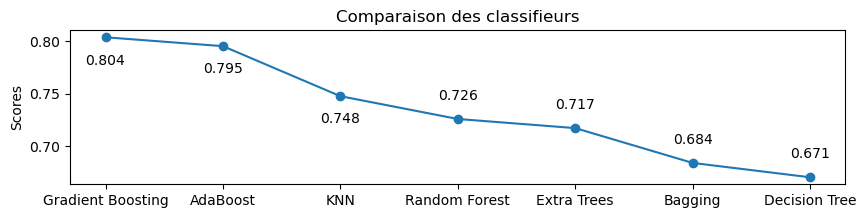

In [12]:
# Tracé des résultats
plt.figure(figsize=(10, 2))
plt.plot(sorted_models['Classifier'], sorted_models['Score'], label='Train score', marker='o')
plt.ylabel('Scores')
plt.title('Comparaison des classifieurs')
#plt.tight_layout()  # Ajustement de la disposition

# Affichage des valeurs au-dessus des points
for i, (classifier, recall) in enumerate(zip(sorted_models['Classifier'], sorted_models['Score'])):
    if i  < 3 :
        plt.text(i, recall, f'\n{recall:.3f}', ha='center', va='top')
    else :
        plt.text(i, recall, f'{recall:.3f}\n', ha='center', va='bottom')

plt.show()

## Optimisation des modèles
Afin d'obtenir de meilleurs résultats, les modèles les plus performants de l'étape précédente vont être optimisés puis comparés à nouveau.

In [13]:
# Fonction pour effectuer la recherche et afficher les résultats
def perform_search(name, pipeline, params, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    search = RandomizedSearchCV(pipeline, params, cv=5, scoring=custom_scoring, n_iter=50, n_jobs=-1, random_state=42, error_score='raise')
    search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best score for {name}: {search.best_score_}")
    
    y_pred = search.predict(X_test)
    print(f"Classification report for {name}:\n {classification_report(y_test, y_pred, zero_division=0)}")
    
    return search

### KNN
Le premier modèle testé est KNN. Celui-ci n'est pas le plus performant, mais il est le modèle le plus simple et va permettre de faire des tests avant d'effectuer les optimisations sur les autres modèles, plus complexes et donc plus lents à optimiser.

In [14]:
# Pipeline KNN
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),    
    ('variance_threshold', VarianceThreshold(0.0)),
    ('selector', SelectKBest()),
    ('classifier', KNeighborsClassifier())
])

params_knn = {
    'selector__score_func': [chi2, f_classif, mutual_info_classif],
    'selector__k': ["all"] + list(range(5, nbr_features, 5)),
    'classifier__n_neighbors': [10, 20, 30, 50, 75, 100, 200, 300, 400, 500, 600],
    'classifier__weights': ['uniform', 'distance']
}

search_knn = perform_search('KNN', pipeline_knn, params_knn)

Best parameters for KNN: {'selector__score_func': <function mutual_info_classif at 0x000002894298F4C0>, 'selector__k': 5, 'classifier__weights': 'uniform', 'classifier__n_neighbors': 400}
Best score for KNN: 0.7964060691271133
Classification report for KNN:
               precision    recall  f1-score   support

           0       0.97      0.55      0.70      7855
           1       0.13      0.80      0.22       629

    accuracy                           0.57      8484
   macro avg       0.55      0.68      0.46      8484
weighted avg       0.91      0.57      0.67      8484



La méthode de KNN varie grandement avec le choix de k, raison pour laquelle, après quelques tests grâce auxquels nous avons pu déterminer les meilleurs paramètres de notre pipeline, nous allons également tester la variation de k, de manière plus précise.

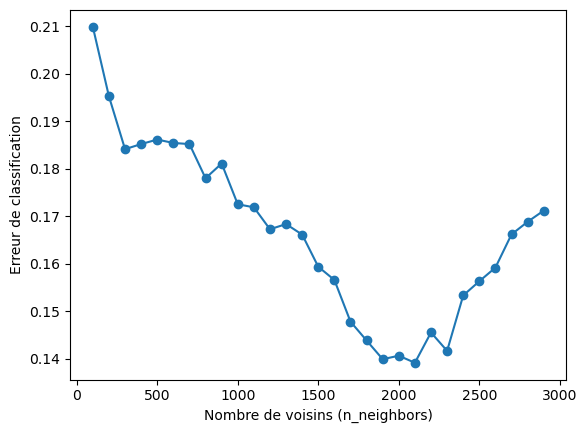

In [15]:
test_pipeline = Pipeline([
    ('preprocessor', preprocessor),    
    ('variance_threshold', VarianceThreshold(0.0)),
    ('selector', SelectKBest(score_func=chi2, k=5)),
    ('classifier', KNeighborsClassifier(weights='uniform'))
])

errors = []

k_values = range(100, 3000, 100)
for k in k_values:
    # Mettre à jour le pipeline avec la valeur de n_neighbors
    test_pipeline.set_params(classifier__n_neighbors=k)
    
    # Effectuer une validation croisée pour obtenir l'erreur de classification moyenne
    scores = cross_val_score(test_pipeline, X_train, y_train, cv=5, scoring=custom_scoring)
    
    # Calculer l'erreur de classification
    error = 1 - scores.mean()
    errors.append(error)

# Tracer la courbe du coude
plt.plot(k_values, errors, marker='o')
plt.xlabel("Nombre de voisins (n_neighbors)")
plt.ylabel("Erreur de classification")
plt.show()

En analysant ce graphique, nous avons décidé de conserver la valeur de `k=400`, déjà utilisée dans notre pipeline. Cette valeur représente un équilibre satisfaisant entre deux aspects importants : un nombre relativement modéré de voisins, qui permet d'éviter une trop grande complexité computationnelle, et un score de performance globalement acceptable. Ce choix reflète une optimisation entre la précision du modèle et son efficacité, tout en minimisant le risque de surajustement ou d'une généralisation insuffisante.

In [16]:
search_knn.refit

y_pred_knn = search_knn.predict(X)
y_score_knn = search_knn.predict_proba(X)[:, 1]

In [17]:
print(classification_report(gdf['Presence'], y_pred_knn, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.56      0.71     39272
           1       0.13      0.82      0.22      3145

    accuracy                           0.58     42417
   macro avg       0.55      0.69      0.47     42417
weighted avg       0.91      0.58      0.67     42417



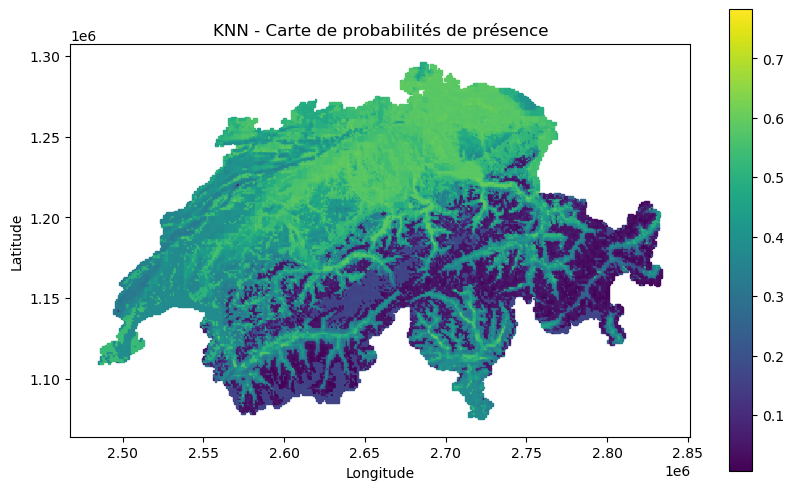

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# Définir une colormap continue
colormap = plt.colormaps.get_cmap('viridis')
normalize = mcolors.Normalize(vmin=y_score_knn.min(), vmax=y_score_knn.max())

# Ajouter chaque cellule avec la couleur basée sur la probabilité
for idx, row in gdf.iterrows():
    polygon = row['geometry']
    value = y_score_knn[idx]
    color = colormap(value)
    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)

# Ajouter une barre de couleur
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Configurer l'affichage
ax.set_title(f'KNN - Carte de probabilités de présence')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

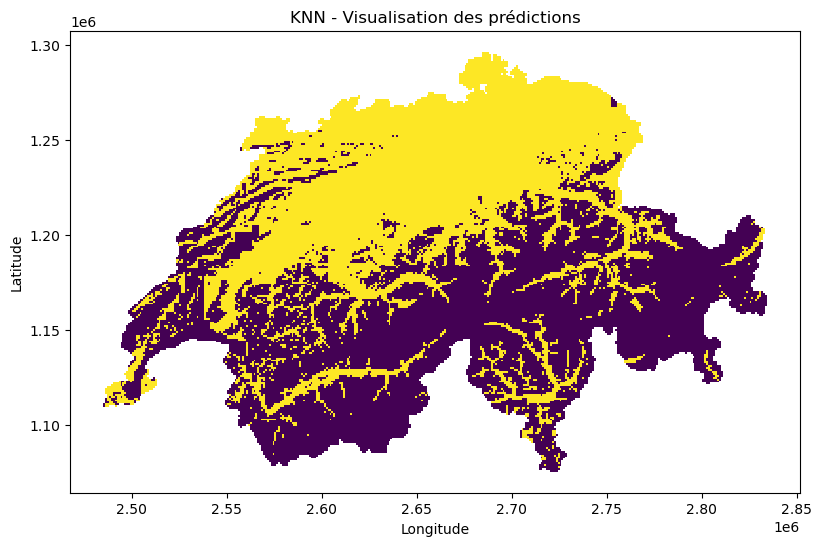

In [19]:
gdf['y_pred_knn'] = y_pred_knn

# Créer une figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer les géométries, en colorant selon les prédictions
gdf.plot(column='y_pred_knn', ax=ax, cmap='viridis')

# Ajouter des détails
ax.set_title('KNN - Visualisation des prédictions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Afficher
plt.show()

### AdaBoost

In [20]:
# Créer un modèle de base (DecisionTreeClassifier)
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

# Pipeline AdaBoost
pipeline_adaboost = Pipeline([
    ('preprocessor', preprocessor),    
    ('variance_threshold', VarianceThreshold(0.0)),
    ('selector', SelectKBest()),
    ('classifier', AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=42))
])

# Paramètres à tester
params_adaboost = {
    'selector__score_func': [chi2, f_classif, mutual_info_classif],
    'selector__k': ["all"] + list(range(5, nbr_features, 5)),
    'classifier__n_estimators': [25, 50, 100, 150, 200, 250, 300],
    'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
    'classifier__estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__estimator__splitter': ['best', 'random'],
    'classifier__estimator__min_samples_leaf': [1, 2, 4, 5, 6, 7, 8, 10]
}

# Exécution de la recherche
search_adaboost = perform_search('AdaBoost', pipeline_adaboost, params_adaboost)

Best parameters for AdaBoost: {'selector__score_func': <function mutual_info_classif at 0x000002894298F4C0>, 'selector__k': 5, 'classifier__n_estimators': 150, 'classifier__learning_rate': 0.001, 'classifier__estimator__splitter': 'best', 'classifier__estimator__min_samples_leaf': 8, 'classifier__estimator__criterion': 'log_loss'}
Best score for AdaBoost: 0.8691159112826305
Classification report for AdaBoost:
               precision    recall  f1-score   support

           0       1.00      0.30      0.46      7855
           1       0.10      0.98      0.18       629

    accuracy                           0.35      8484
   macro avg       0.55      0.64      0.32      8484
weighted avg       0.93      0.35      0.44      8484



In [21]:
search_adaboost.refit

y_pred_ada = search_adaboost.predict(X)
y_score_ada = search_adaboost.predict_proba(X)[:, 1]

In [22]:
print(classification_report(gdf['Presence'], y_pred_ada, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47     39272
           1       0.10      0.99      0.19      3145

    accuracy                           0.36     42417
   macro avg       0.55      0.65      0.33     42417
weighted avg       0.93      0.36      0.45     42417



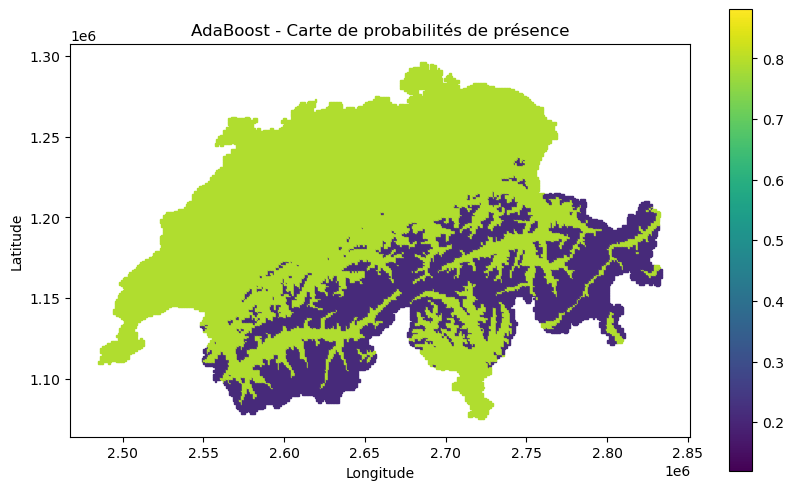

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

# Définir une colormap continue
colormap = plt.colormaps.get_cmap('viridis')
normalize = mcolors.Normalize(vmin=y_score_ada.min(), vmax=y_score_ada.max())

# Ajouter chaque cellule avec la couleur basée sur la probabilité
for idx, row in gdf.iterrows():
    polygon = row['geometry']
    value = y_score_ada[idx]
    color = colormap(value)
    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)

# Ajouter une barre de couleur
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Configurer l'affichage
ax.set_title(f'AdaBoost - Carte de probabilités de présence')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

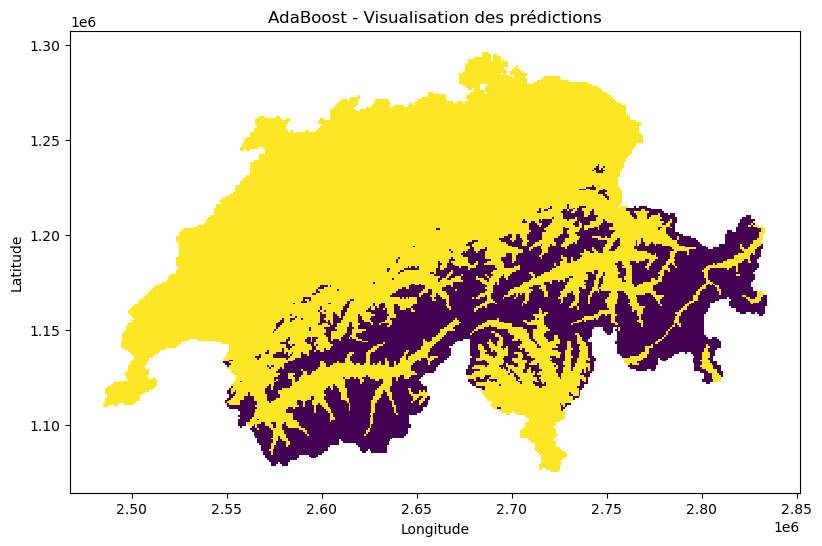

In [24]:
gdf['y_pred_ada'] = y_pred_ada

# Créer une figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer les géométries, en colorant selon les prédictions
gdf.plot(column='y_pred_ada', ax=ax, cmap='viridis')

# Ajouter des détails
ax.set_title('AdaBoost - Visualisation des prédictions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Afficher
plt.show()

### Gradient Boosting

In [25]:
# Pipeline Gradient Boosting
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('variance_threshold', VarianceThreshold(0.0)),
    ('selector', SelectKBest()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Paramètres à tester pour Gradient Boosting
params_gb = {
    'selector__score_func': [chi2, f_classif, mutual_info_classif],
    'selector__k': ["all"] + list(range(5, nbr_features, 5)),
    'classifier__n_estimators': [25, 50, 100, 150, 200, 250, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classifier__max_depth': [1, 3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 5, 6, 7, 8, 10],
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0],
    'classifier__max_features': ['sqrt', 'log2', None]
}

# Exécution de la recherche pour Gradient Boosting
search_gb = perform_search('GradientBoosting', pipeline_gb, params_gb)


Best parameters for GradientBoosting: {'selector__score_func': <function mutual_info_classif at 0x000002894298F4C0>, 'selector__k': 'all', 'classifier__subsample': 0.5, 'classifier__n_estimators': 50, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 7, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 1, 'classifier__learning_rate': 0.01}
Best score for GradientBoosting: 0.837267533354144
Classification report for GradientBoosting:
               precision    recall  f1-score   support

           0       0.98      0.41      0.57      7855
           1       0.11      0.89      0.19       629

    accuracy                           0.44      8484
   macro avg       0.54      0.65      0.38      8484
weighted avg       0.91      0.44      0.55      8484



In [26]:
search_gb.refit

y_pred_gb = search_gb.predict(X)
y_score_gb = search_gb.predict_proba(X)[:, 1]

In [27]:
print(classification_report(gdf['Presence'], y_pred_gb, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.41      0.58     39272
           1       0.11      0.92      0.20      3145

    accuracy                           0.45     42417
   macro avg       0.55      0.67      0.39     42417
weighted avg       0.92      0.45      0.55     42417



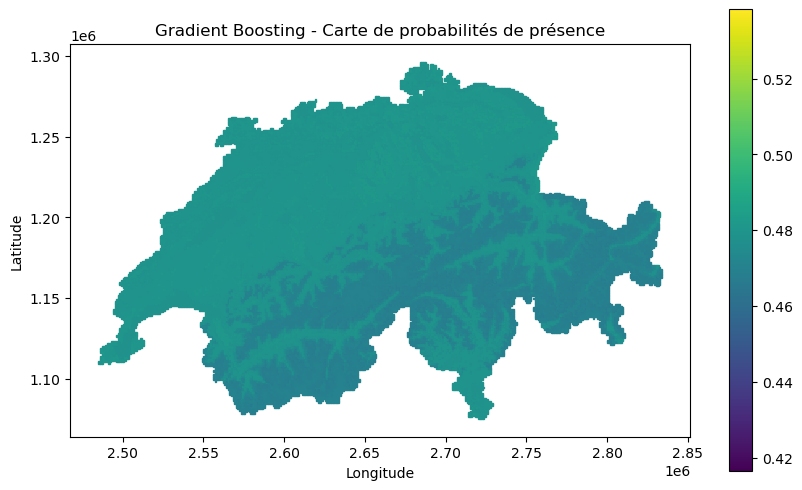

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

# Définir une colormap continue
colormap = plt.colormaps.get_cmap('viridis')
normalize = mcolors.Normalize(vmin=y_score_gb.min(), vmax=y_score_gb.max())

# Ajouter chaque cellule avec la couleur basée sur la probabilité
for idx, row in gdf.iterrows():
    polygon = row['geometry']
    value = y_score_gb[idx]
    color = colormap(value)
    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)

# Ajouter une barre de couleur
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Configurer l'affichage
ax.set_title(f'Gradient Boosting - Carte de probabilités de présence')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

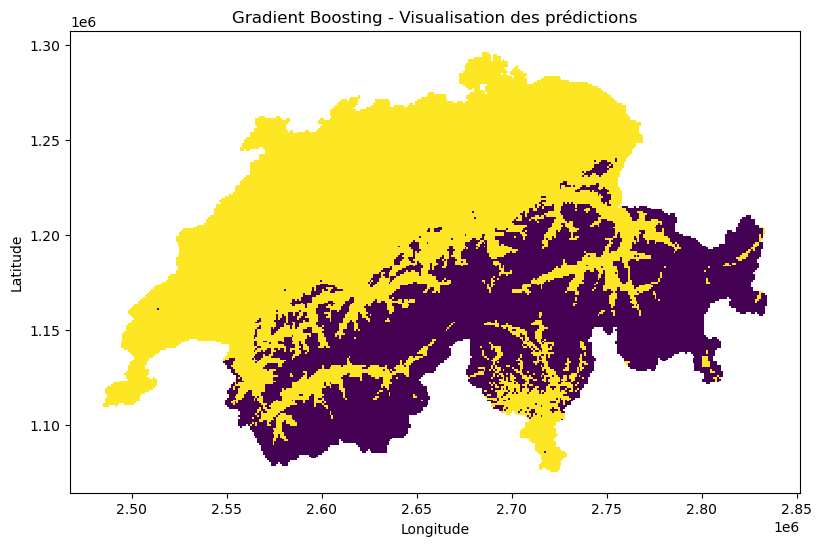

In [29]:
gdf['y_pred_gb'] = y_pred_gb

# Créer une figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer les géométries, en colorant selon les prédictions
gdf.plot(column='y_pred_gb', ax=ax, cmap='viridis')

# Ajouter des détails
ax.set_title('Gradient Boosting - Visualisation des prédictions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Afficher
plt.show()

### Random Forest

In [30]:
# Pipeline Random Forest
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),    
    ('variance_threshold', VarianceThreshold(0.0)),
    ('select', SelectKBest()),
    ('clf', RandomForestClassifier())
])

params_dt = {
    'select__score_func': [chi2, f_classif, mutual_info_classif],
    'select__k': ["all"] + list(range(5, nbr_features, 5)),
    'clf__n_estimators': [100, 150, 200, 250, 300, 400, 500],
    'clf__max_depth': [None, 5, 10, 15, 20, 25, 30],
    'clf__min_samples_split': [2, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 4, 5, 6, 7, 8, 10],
    'clf__max_features': ['sqrt', 'log2']
}

search_rf = perform_search('Random Forest', pipeline_dt, params_dt)

Best parameters for Random Forest: {'select__score_func': <function mutual_info_classif at 0x000002894298F4C0>, 'select__k': 'all', 'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__max_depth': 5}
Best score for Random Forest: 0.8382899304585563
Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.98      0.45      0.61      7855
           1       0.11      0.89      0.20       629

    accuracy                           0.48      8484
   macro avg       0.55      0.67      0.41      8484
weighted avg       0.92      0.48      0.58      8484



In [31]:
search_rf.refit

y_pred_rf = search_rf.predict(X)
y_score_rf = search_rf.predict_proba(X)[:, 1]

In [32]:
print(classification_report(gdf['Presence'], y_pred_rf, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.45      0.61     39272
           1       0.12      0.92      0.21      3145

    accuracy                           0.48     42417
   macro avg       0.55      0.68      0.41     42417
weighted avg       0.92      0.48      0.58     42417



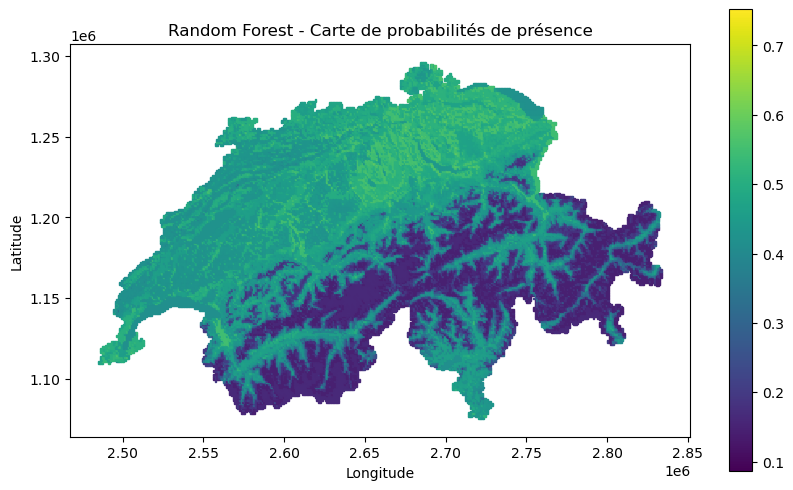

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

# Définir une colormap continue
colormap = plt.colormaps.get_cmap('viridis')
normalize = mcolors.Normalize(vmin=y_score_rf.min(), vmax=y_score_rf.max())

# Ajouter chaque cellule avec la couleur basée sur la probabilité
for idx, row in gdf.iterrows():
    polygon = row['geometry']
    value = y_score_rf[idx]
    color = colormap(value)
    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)

# Ajouter une barre de couleur
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Configurer l'affichage
ax.set_title(f'Random Forest - Carte de probabilités de présence')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

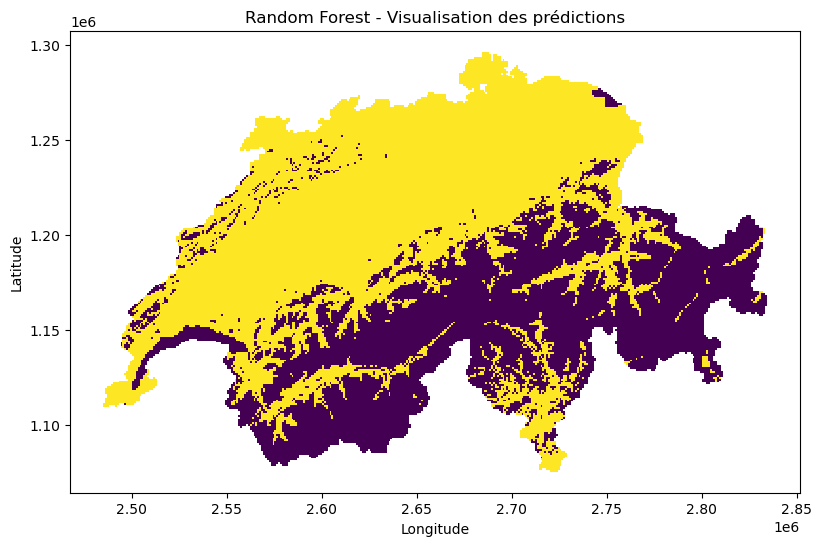

In [34]:
gdf['y_pred_rf'] = y_pred_rf

# Créer une figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer les géométries, en colorant selon les prédictions
gdf.plot(column='y_pred_rf', ax=ax, cmap='viridis')

# Ajouter des détails
ax.set_title('Random Forest - Visualisation des prédictions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Afficher
plt.show()

### Comparaison des prédictions

Afin de pouvoir mieux comparer les différentes prédiction de nos modèles, nous avons affichés une carte avec la somme des votes des modèles.

In [35]:
gdf['Votes'] = gdf[['y_pred_knn', 'y_pred_ada', 'y_pred_gb', 'y_pred_rf']].sum(axis=1)

In [38]:
gdf['y_pred'] = (gdf['Votes'] >= 2).astype(int)

print(classification_report(gdf['Presence'], gdf['y_pred'], zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.39      0.56     39272
           1       0.11      0.94      0.20      3145

    accuracy                           0.43     42417
   macro avg       0.55      0.67      0.38     42417
weighted avg       0.92      0.43      0.53     42417



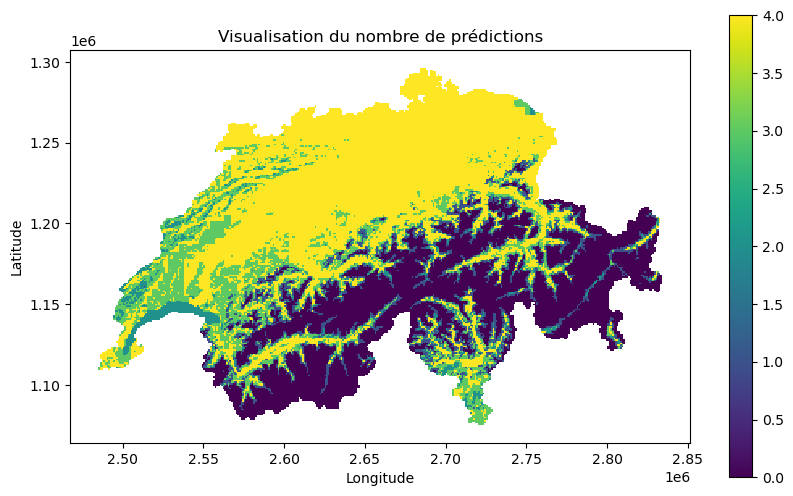

In [36]:
# Créer une figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer les géométries, en colorant selon les prédictions
gdf.plot(column='Votes', ax=ax, legend=True, cmap='viridis')

# Ajouter des détails
ax.set_title('Visualisation du nombre de prédictions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Afficher
plt.show()